In [87]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['HUGGINGFACE_API_KEY'] = os.getenv('HUGGINGFACE_API_KEY')

from langchain_groq import ChatGroq
llm = ChatGroq(model_name="qwen/qwen3-32b")

In [88]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [89]:
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(url)
data = loader.load()

In [90]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=25)
doc_splits = text_splitter.split_documents(data)

In [91]:
from langchain_community.vectorstores import Chroma
db = Chroma.from_documents(doc_splits, embeddings,collection_name="rag-chroma")
retriever = db.as_retriever()

In [92]:
from langchain_core.messages import AIMessage

def retrieve(state):
    print("\n" + "="*20 + " NODE: RETRIEVE " + "="*20)
    messages = state["messages"]
    question = messages[0].content
    print(f"Input Question: {question}")
    documents = retriever.invoke(question)
    print(f"Action: Retrieved {len(documents)} documents from vector store.")
    return {"messages": [AIMessage(content=str(documents))]}

retriever_node = retrieve

In [93]:
from typing import Annotated, Sequence, TypedDict
from langgraph.graph.message import BaseMessage, add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langsmith import Client

client = Client()
prompt = client.pull_prompt("rlm/rag-prompt")

class grade(BaseModel):
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [94]:
def grade_documents(state: AgentState):
    from langchain_core.output_parsers import JsonOutputParser
    import json
    import re
    parser = JsonOutputParser(pydantic_object=grade)
    
    prompt = PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    
                    {format_instructions}
                    
                    IMPORTANT: Return ONLY the JSON object. Do not include any explanation, reasoning, or preamble.""",
                    input_variables=["context", "question"],
                    partial_variables={"format_instructions": parser.get_format_instructions()}
                    )

    chain = prompt | llm
    message = state["messages"]
    last_message = message[-1]
    docs = last_message.content
    question = message[0].content

    print("\n" + "="*20 + " NODE: GRADE DOCUMENTS " + "="*20)
    print(f"Grading relevance of retrieved documents to question: {question}")
    
    response = chain.invoke({"question":question,"context":docs})
    response_content = response.content
    
    # Remove <think> tags if present
    response_content = re.sub(r'<think>.*?</think>', '', response_content, flags=re.DOTALL)
    
    try:
        scored_result = parser.parse(response_content)
    except Exception as e:
        print(f"JSON parse error: {e}. Trying regex fallback.")
        # Fallback to finding the first JSON object
        try:
            match = re.search(r'\{.*\}', response_content, re.DOTALL)
            if match:
                import json
                scored_result = json.loads(match.group(0))
            else:
                scored_result = {"binary_score": "no"}
        except:
             scored_result = {"binary_score": "no"}

    score = scored_result["binary_score"]

    if score == "yes":
        print(f"Decision: DOCUMENTS ARE RELEVANT (Score: {score})")
        print("Path: -> output generator")
        return "generator"
    else:
        print(f"Decision: DOCUMENTS ARE NOT RELEVANT (Score: {score})")
        print("Path: -> query rewriter")
        return "rewriter"


In [95]:
def generate(state: AgentState):
    print("\n" + "="*20 + " NODE: GENERATE RESPONSE " + "="*20)
    
    message=state["messages"]
    question=message[0].content
    
    last_message = message[-1]
    docs = last_message.content
    
    prompt = client.pull_prompt("rlm/rag-prompt")
    rag_chain = prompt | llm
    
    print("Action: Generating final response using context.")
    response=rag_chain.invoke({"context": docs, "question": question})
    
    print(f"Generated Response:\n{response.content}")
    
    return {"messages": [response]}

In [96]:
def rewrite(state:AgentState):
    print("\n" + "="*20 + " NODE: REWRITE QUERY " + "="*20)
    message=state["messages"]
    
    question=message[0].content
    print(f"Initial Question: {question}")
    
    input= [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]

    response=llm.invoke(input)
    print(f"Action: Rewrote query to improve retrieval.")
    print(f"Rewritten Question: {response.content}")
    
    return {"messages": [response]}



In [97]:
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()

def web_search(state: AgentState):
    print("\n" + "="*20 + " NODE: WEB SEARCH " + "="*20)
    message=state["messages"]
    question=message[0].content
    print(f"Search Query: {question}")

    # Execute search directly to get results for the generator
    results = search.invoke(question)
    print(f"Action: Performed web search.")
    print(f"Web Search Result (truncated): {results[:200]}...")
    return {"messages": [AIMessage(content=results)]}

In [98]:
from langgraph.graph import END, START, StateGraph
workflow = StateGraph(AgentState)
workflow.add_node("vector retriever", retriever_node)
workflow.add_node("query rewriter", rewrite)
workflow.add_node("output generator", generate)
workflow.add_node("web search", web_search)

In [99]:
workflow.add_edge(START, "vector retriever")
workflow.add_conditional_edges(
    "vector retriever",
    grade_documents,
    {   "generator": "output generator",
        "rewriter": "query rewriter"
    },
)
workflow.add_edge("query rewriter", "web search")
workflow.add_edge("web search", "output generator")
workflow.add_edge("output generator", END)

In [100]:
app = workflow.compile()

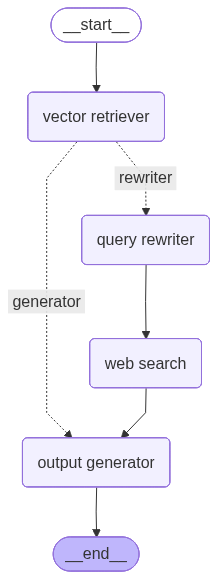

In [101]:
app

In [102]:
app.invoke({"messages":"what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?"})


==================== NODE: RETRIEVE ====================
Input Question: what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?
Action: Retrieved 4 documents from vector store.

==================== NODE: GRADE DOCUMENTS ====================
Grading relevance of retrieved documents to question: what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?
Decision: DOCUMENTS ARE RELEVANT (Score: yes)
Path: -> output generator

==================== NODE: GENERATE RESPONSE ====================
Action: Generating final response using context.
Generated Response:
<think>
Okay, the user is asking about LLM-powered autonomous agents, specifically planning, reflection, and prompt engineering in the context of agents and LangChain. Let me break this down.

First, I need to recall the information from the provided documents. The 

{'messages': [HumanMessage(content='what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='14805feb-e25e-485e-9cf2-748e9f7e5874'),
  AIMessage(content='[Document(metadata={\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\', \'description\': \'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\\nAgent System Overview\\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\\n\\nPlanning\\n\\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable su

In [104]:
print("\n\nTesting with irrelevant question to trigger rewrite and web search:")
response = app.invoke({"messages":"How to make a pepperoni pizza?"})



Testing with irrelevant question to trigger rewrite and web search:

==================== NODE: RETRIEVE ====================
Input Question: How to make a pepperoni pizza?
Action: Retrieved 4 documents from vector store.

==================== NODE: GRADE DOCUMENTS ====================
Grading relevance of retrieved documents to question: How to make a pepperoni pizza?


Decision: DOCUMENTS ARE NOT RELEVANT (Score: no)
Path: -> query rewriter

==================== NODE: REWRITE QUERY ====================
Initial Question: How to make a pepperoni pizza?
Action: Rewrote query to improve retrieval.
Rewritten Question: <think>
Okay, let's tackle this. The user wants me to look at the input question "How to make a pepperoni pizza?" and come up with an improved version. First, I need to understand the original question's intent. The user is asking for instructions on making a pepperoni pizza. But maybe they want more than just the basic steps. Let me think about possible areas where the original question could be enhanced.

The original question is pretty straightforward, but maybe it's too vague. For example, do they want a homemade pizza from scratch, or a quick version using store-bought dough? Also, are there specific dietary restrictions they might have in mind, like gluten-free or vegan? The term "pepperoni pizza" can vary widely. Some people might wan

In [108]:
response["messages"][-1].content

"<think>\nOkay, the user wants to know how to make a pepperoni pizza. Let me check the provided context.\n\nThe context mentions several key points: making homemade dough, using a tangy sauce, adding gooey cheese, and plenty of pepperoni. It also suggests hiding extra pepperoni under the cheese for more flavor. There's a mention of a deep dish-style recipe and using Pillsbury crust as a shortcut. \n\nI need to condense this into three concise sentences. Start with the basic steps: dough, sauce, cheese, pepperoni. Highlight the tip about hiding extra pepperoni. Mention the option of using pre-made crust for convenience. Make sure it's clear and follows the context without adding extra info. Let me piece that together.\n</think>\n\nTo make a pepperoni pizza, start with homemade dough, spread tangy sauce, add gooey cheese, and top with plenty of pepperoni slices. For extra flavor, hide additional pepperoni under the cheese layer. Use a deep dish-style crust or a pre-made crust like Pillsb